# Bootstrap

__Goal__: illustrate the bootstrap and check that the distribution of entropies after resampling follows a normal distribution

In [57]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.abspath(), "..", ".."))

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from infovar.stats import entropy_estimators as ee

plt.rc("text", usetex=True)

## Analytical example

In [13]:
n_samples = 10_000

sigma = 1
sigma_add = 1e-2

data = np.random.normal(0, sigma, n_samples)
data[:n_samples//2] = data[n_samples//2:]
data += np.random.normal(0, sigma_add, n_samples)
data = data.reshape(-1, 1)

h = entropy(data)
href = 0.5 * np.log2(2*np.pi*np.e*sigma**2)
href2 = 0.5 * np.log2(2*np.pi*np.e*(sigma**2 + sigma_add**2))

In [14]:
h, href, href2

(2.031601796142712, 2.047095585180641, 2.047167716326188)

## Data loading

In [15]:
param = 'dust-av'
line = 'c18o10'

x = astro30m.load_line_integral(line, 2020).data.reshape(-1, 1)
y = astro30m.load_phys_quantity(param, 2020).data.reshape(-1, 1)

x = np.log10(np.abs(x))
y = np.log10(np.abs(y))

n = x.shape[0]

## Influence of additive Gaussian noise to prevent degeneracy during bootstrap

In [43]:
stds = np.logspace(-8, 2, 50)

idx = np.random.choice(n, n, replace=True)
hs = np.zeros_like(stds)
for i, std in enumerate(tqdm(stds)):
    _x = x[idx] + np.random.normal(0, std, x.shape)
    _y = y[idx]
    hs[i] = centropy(_y, _x)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [03:14<00:00,  3.90s/it]


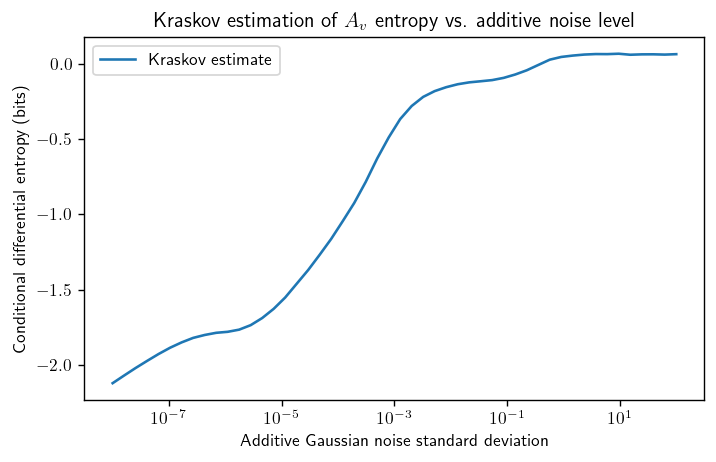

In [44]:
plt.figure(figsize=(6.4, 0.8*4.8), dpi=125)

plt.semilogx(stds, hs, label=f'Kraskov estimate')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Conditional differential entropy (bits)')
plt.title(f"Kraskov estimation of {astro30m.latex_quantity(param)} entropy vs. additive noise level")
plt.legend()

plt.show()

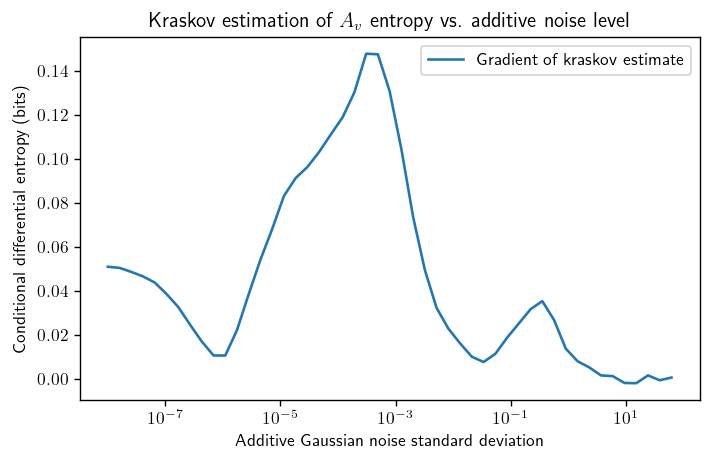

In [45]:
plt.figure(figsize=(6.4, 0.8*4.8), dpi=125)

grad = np.gradient(hs)

plt.semilogx(stds[:-1], grad[:-1], label=f'Gradient of kraskov estimate')

plt.xlabel('Additive Gaussian noise standard deviation')
plt.ylabel('Conditional differential entropy (bits)')
plt.title(f"Kraskov estimation of {astro30m.latex_quantity(param)} entropy vs. additive noise level")
plt.legend()

plt.show()

## True entropy

In [48]:
noise_std = 5e-2 # To prevent degeneracy

_x = x + np.random.normal(0, noise_std, x.shape)
_y = y# + np.random.normal(0, noise_std, y.shape)

h = centropy(_y, _x)

## Entropy after resampling

In [53]:
iters = 200

hs = np.zeros(iters)
for i in tqdm(range(iters)):
    idx = np.random.choice(n, n, replace=True)
    _x = x[idx] + np.random.normal(0, noise_std, x.shape)
    _y = y[idx]# + np.random.normal(0, noise_std, y.shape)

    hs[i] = centropy(_y, _x)

100%|██████████| 200/200 [12:31<00:00,  3.76s/it]


## Histograms

In [54]:
mu = np.mean(hs)
sigma = np.std(hs)

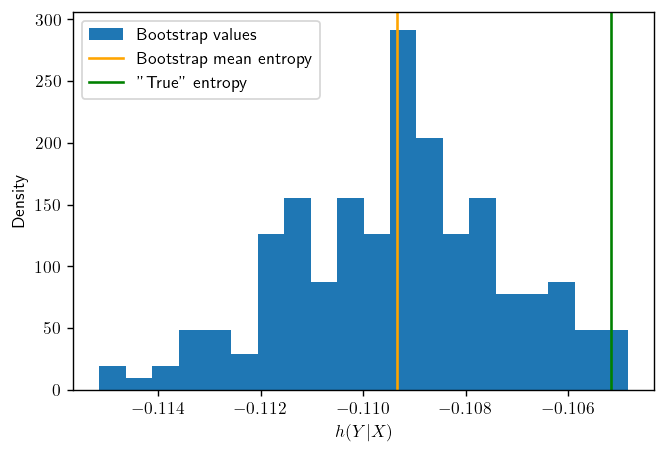

In [55]:
plt.figure(dpi=125)

plt.hist(hs, bins=iters//10, density=True, label='Bootstrap values')
plt.axvline(mu, color='orange', label='Bootstrap mean entropy')
plt.axvline(h, color='green', label='"True" entropy')
plt.xlabel("$h(Y|X)$")
plt.ylabel("Density")
plt.legend()

plt.show()

## Confidence interval

In [56]:
print(f"h(Y|X): {h:.3f}")
print(f"mu: {mu:.3f}")
print(f"sigma: {sigma:.3f}")
print(f"CI (95%): [{h-2*sigma:.3f}, {h+2*sigma:.3f}]")

h(Y|X): -0.105
mu: -0.109
sigma: 0.002
CI (95%): [-0.109, -0.101]


In [60]:
%%timeit
centropy(_y, _x)

3.93 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit
mi(_y, _x)

6.01 s ± 195 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
